## **IMPORTS**|

In [401]:
#IMPORTS
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math
from skimage.metrics import structural_similarity as compare_ssim
from scipy.signal import medfilt2d

In [402]:
fN = "CSE483 Sp24 Project Test Cases/" #folderName
img_array = [fN+'01-Getting-started.png',fN+'02-Matsawar-3edel-ya3am.png', fN+'03-Leffy-bina-ya-donya.png',
             fN+'04-Black-mirror.png',fN+'05-Caesar-cipher.png', fN+'06-Railfence-cipher.png',
             fN+'07-THE-MIGHTY-FINGER.png', fN+'08-Compresso-Espresso.png', fN+'09-My-phone-fell-while-taking-this-one-...-or-did-it.png', fN+'10-Gone-With-The-Wind.png', fN+'11-weewooweewooweewoo.png',
             fN+'12-mal7-w-felfel.png', fN+'13-2el-noor-2ata3.png',fN+'14-BANANAAA!!!.png',
             fN+'15-beast-mode-computer-vision-(this-one-is-from-wikipedia).jpg',
             fN+'16-V3-QR-Code...-can-you-do-it.png']

TEST_CASE = 0
img_address = img_array[TEST_CASE]

## *PREPROCESSING*

In [403]:
def median_filter(img, size):
    median = cv2.medianBlur(img, size)
    return median

def smoothing_filter(img):

    return 0

def constrast_stretching(gray):
    # Calculate the minimum and maximum pixel values
    min_val = np.min(gray)
    max_val = np.max(gray)

    # Define the new minimum and maximum values for contrast stretching
    new_min = 0
    new_max = 255

    # Apply contrast stretching
    stretched_image = ((gray - min_val) / (max_val - min_val)) * (new_max - new_min) + new_min

    # Convert the image back to uint8 format
    stretched_image = np.uint8(stretched_image)
    return stretched_image


def brighten_filter(img_gray):
    brightened_img = [pixel if (pixel >= 128) else pixel + 128 for pixel in img_gray.ravel()]
    brightened_img_reshaped = np.reshape(brightened_img, img_gray.shape)
    return brightened_img_reshaped

def rotate_img(img):

    # Rotate the image
    rotated_img = cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)
    return rotated_img

def show_histogram(img):
    plt.figure(figsize=(9,8))
    plt.hist(img.ravel(), bins=256)

def sharpening_filter(img_gray, kernel_size):
    image_float32 = np.float32(img_gray)
    blurred = cv2.GaussianBlur(img_gray, (kernel_size, kernel_size), 0)
    blurred_float32 = np.float32(blurred)

    # Calculate the unsharp mask (original image - blurred image)
    unsharp_mask = cv2.subtract(image_float32, blurred_float32)

    # Add the unsharp mask to the original image to sharpen it
    sharpened = cv2.add(image_float32, unsharp_mask)
    sharpened = np.clip(sharpened, 0, 255)  # Clip values to 0-255 range
    sharpened = np.uint8(sharpened)
    return sharpened

def opening_filter(img):
    closed_img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (13, 13)))
    # plt.imshow(thresh1, cmap="grey")

    return closed_img

def get_contours(img):
    #img taken into the contours must be binarized (applying greyscale then threshold) for better accuracy

    ## *object to be found should be white and background should be black* ##

    # Find contours in the binary image
    contours, _ = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # Find the contour with the largest area (assuming it's the outer frame of the QR code)
    largest_contour = max(contours, key=cv2.contourArea)
    # Get the bounding (corner points) of the rectangle of the contour
    x, y, w, h = cv2.boundingRect(largest_contour)

    # Crop the image to the bounding rectangle to Extract the QR code region
    qr_code_frame = img[y:y+h, x:x+w]

    # Straightening into a square (assuming the frame is already rectangular)
    # Find the longer side of the rectangle
    if w > h:
        max_dim = w
    else:
        max_dim = h

    # Create a square image with dimensions equal to the maximum dimension
    square_img = np.zeros((max_dim, max_dim), dtype=np.uint8)
    # Calculate the position to paste the rectangle in the center of the square image
    x_pos = (max_dim - w) // 2
    y_pos = (max_dim - h) // 2
    # Paste the rectangle onto the square image
    square_img[y_pos:y_pos+h, x_pos:x_pos+w] = qr_code_frame
    return square_img

def invert_qr(img):
    inverted_img = cv2.bitwise_not(img)
    return inverted_img

def adaptive_threshold(img, blockSize, C):
    adptv_threshed_img = cv2.adaptiveThreshold(
    src=img,
    maxValue=255,
    adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C,  # read: https://docs.opencv.org/3.4/d7/d1b/group__imgproc__misc.html#gaa42a3e6ef26247da787bf34030ed772c
    thresholdType=cv2.THRESH_BINARY,
    blockSize=blockSize,  # NxN block size (odd) to perform adaptive threshold on
    C=C  # Constant subtracted from the mean or weighted mean
    )

    return adptv_threshed_img


def flip_image(img):
    img = cv2.flip(img,1)
    return img

def fourier(image):
    dft_img = np.fft.fft2(image)
    dft_img_shift = np.fft.fftshift(dft_img)

    return dft_img_shift

def histogram_equalizer(img):
    equalized_img = cv2.equalizeHist(img)
    return equalized_img

def shift_image(image, dx, dy):
    shifted_image = np.roll(image, dy, axis=0)  # Shift rows
    shifted_image = np.roll(shifted_image, dx, axis=1)  # Shift columns
    return shifted_image

def replicate_padding(image, padding_size):
    return cv2.copyMakeBorder(image, padding_size, padding_size, padding_size, padding_size, cv2.BORDER_REPLICATE)

def zero_padding(image, padding_size):
    return cv2.copyMakeBorder(image, padding_size, padding_size, padding_size, padding_size, cv2.BORDER_CONSTANT, value=0)

def mirror_padding(image, padding_size):
    return cv2.copyMakeBorder(image, padding_size, padding_size, padding_size, padding_size, cv2.BORDER_REFLECT)

def straighten_image(image):
    # Apply edge detection or any other suitable method to detect edges
    edges = cv2.Canny(image, 50, 150, apertureSize=3)

    # Apply Hough Line Transform to detect lines
    lines = cv2.HoughLines(edges, 1, np.pi / 180, 127)
    print(lines)
    # Calculate rotation angle
    # Calculate rotation angle
    total_angle = 0.0
    if lines is not None:
        for line in lines:
            rho, theta = line[0]  # Extract rho and theta from the current line
            total_angle += np.degrees(theta)
        angle = total_angle / len(lines)


    # Rotate the image
    center = (image.shape[1] // 2, image.shape[0] // 2)
    rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated_image = cv2.warpAffine(image, rotation_matrix, (image.shape[1], image.shape[0]), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)

    return rotated_image

def binary_threshold(img, threshold):
    _, thresholded_image = cv2.threshold(img, threshold, 255, cv2.THRESH_BINARY)
    return thresholded_image


## *Filter functions*

In [404]:
def give_me_circle_mask_nowww(mask_size, radius):
    mask = np.zeros(mask_size)
    cy = mask.shape[0] // 2
    cx = mask.shape[1] // 2
    return cv2.circle(mask, (cx,cy), radius, (255,255,255), -1).astype(np.uint8)

def try_lowpass(dft_img, limit, gaussian: bool = False):
    mask = give_me_circle_mask_nowww(dft_img.shape, limit)
    if (gaussian):
        mask = cv2.GaussianBlur(mask, (21,21), 0)
    dft_img_shifted = np.fft.fftshift(dft_img)
    dft_img_shifted_lowpass = np.multiply(dft_img_shifted, mask)
    # Step 3: Convert back to spatial domain
    f_ishift = np.fft.ifftshift(dft_img_shifted_lowpass)
    img_back = np.fft.ifft2(f_ishift)
    img_back = np.abs(img_back)
    return img_back

def try_highpass(dft_img, limit, gaussian: bool = False, keep_dc: bool = False):
    mask = ~give_me_circle_mask_nowww(dft_img.shape, limit)
    if (gaussian):
        mask = cv2.GaussianBlur(mask, (21,21), 0)
    if (keep_dc):
        mask[dft_img.shape[0]//2, dft_img.shape[1]//2] = 255
    dft_img_shifted = np.fft.fftshift(dft_img)
    dft_img_shifted_highpass = np.multiply(dft_img_shifted, mask)
    # Step 3: Convert back to spatial domain
    f_ishift = np.fft.ifftshift(dft_img_shifted_highpass)
    img_back = np.fft.ifft2(f_ishift)
    img_back = np.abs(img_back)

    # Normalize pixel values to range [0, 255]
    img_back = cv2.normalize(img_back, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

    return img_back

def plot_shifted_fft_and_ifft(dft_img_shifted):
    img = np.fft.ifft2(np.fft.ifftshift(dft_img_shifted))
    fig, (ax1, ax2) = plt.subplots(figsize=(10, 5), nrows=1, ncols=2)
    ax1.set(yticks=[0, img.shape[0]//2, img.shape[0] - 1], yticklabels=[-img.shape[0]//2, 0, img.shape[0]//2 - 1]);
    ax1.set(xticks=[0, img.shape[1]//2, img.shape[1] - 1], xticklabels=[-img.shape[1]//2, 0, img.shape[1]//2 - 1]);
    ax1.imshow(np.abs(dft_img_shifted)**0.1, cmap = 'gray');
    ax2.imshow(np.abs(img), cmap = 'gray')
    return dft_img_shifted

In [405]:
def biggestContour (contours):
    biggest=np.array([])

    max_area=0
    for i in contours:
        area=cv2.contourArea(i)
        if area>1000:
            peri=cv2.arcLength(i,True)
            approx=cv2.approxPolyDP(i,0.02*peri,True)
            if area > max_area and len(approx)==4:
                biggest=approx
                max_area=area
    return biggest,max_area
def reorder(myPoints):
    myPoints=myPoints.reshape((4,2))
    myPointsNew=np.zeros((4,1,2),dtype=np.int32)
    add=myPoints.sum(1)
    myPointsNew[0]=myPoints[np.argmin(add)]
    myPointsNew[3]=myPoints[np.argmax(add)]
    diff=np.diff(myPoints,axis=1)
    myPointsNew[1]=myPoints[np.argmin(diff)]
    myPointsNew[2]=myPoints[np.argmax(diff)]
    return myPointsNew

### Finding the placement boxes contours

In [406]:
# image = cv2.imread(img_address)
#
# angle = -15  # Adjust the angle as desired  # Get the image's height and width
# height, width = image.shape[:2]
# # Calculate the rotation matrix
# rotation_matrix = cv2.getRotationMatrix2D((width / 2, height / 2), angle, 1)
# # Apply the rotation to the
#
# # Define the border width
# border_width = 1
#
# # Create a border with a single black pixel
# border_image = cv2.copyMakeBorder(image, border_width, border_width, border_width, border_width, cv2.BORDER_CONSTANT, value=(0, 0, 0))
#
# rotated_image = cv2.warpAffine(border_image, rotation_matrix, (width, height))

Bounding Box Size: (width=309, height=309)
Rotate flag:  False
Bounding Box 1: (x=43, y=659)
Bounding Box 2: (x=659, y=43)
Bounding Box 3: (x=43, y=43)


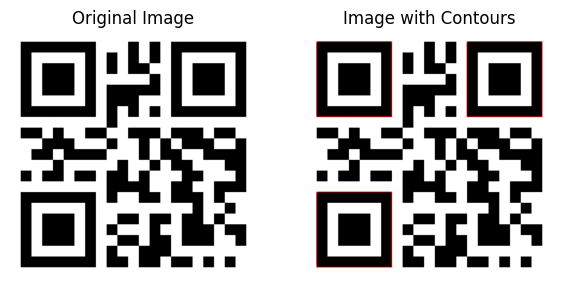

In [407]:
try:
    fig, axes = plt.subplots(1, 2, figsize=(7, 7))
    RotateFlag = False
    # versionFlag
    # Load the image containing the QR code
    image = cv2.imread(img_address)
    # image = rotated_image
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Perform edge detection using Canny
    edges = cv2.Canny(blurred, 50, 150)

    # Find contours in the edge-detected image
    contours, _ = cv2.findContours(edges.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Find the largest contour(s) by area
    max_area = max(cv2.contourArea(contour) for contour in contours)
    largest_contours = [contour for contour in contours if cv2.contourArea(contour) > 0.9 * max_area]
    # List to store the coordinates of bounding boxes
    bounding_box_coordinates = []
        # Initialize variables to store bounding box size
    bounding_box_width = 0
    bounding_box_height = 0
    # Get bounding box coordinates for the largest contours
    for contour in largest_contours:
        # Get bounding box
        x, y, w, h = cv2.boundingRect(contour)
        # Append the coordinates of the top-left corner (x, y) to the list
        bounding_box_coordinates.append((x, y))
        bounding_box_width = w
        bounding_box_height = h



    print(f"Bounding Box Size: (width={bounding_box_width}, height={bounding_box_height})")

    # Extract all values from tuples in the list
    all_values = [value for pair in bounding_box_coordinates for value in pair]
    # Find the maximum value
    max_value = max(all_values)
    # print("Maximum value:", max_value)
    # Check if the specified coordinates are present in any of the bounding boxes
    if len(bounding_box_coordinates)>1:
        if any((x == max_value and y == max_value) for x, y in bounding_box_coordinates):
            # Rotate the image by 180 degrees
            RotateFlag = True

    print("Rotate flag: ", RotateFlag)
    # Print the coordinates of the bounding boxes
    for i, (x, y) in enumerate(bounding_box_coordinates):
        print(f"Bounding Box {i + 1}: (x={x}, y={y})")
    # Create a copy of the original image to draw the largest contour on
    image_with_contours = image.copy()

    # Draw the largest contour(s) with a red border
    cv2.drawContours(image_with_contours, largest_contours, -1, (0, 0, 255), 2)

    # Convert BGR image to RGB for displaying with matplotlib
    image_with_contours_rgb = cv2.cvtColor(image_with_contours, cv2.COLOR_BGR2RGB)

    # Plot the images side by side

    # Plot the original image
    axes[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    if RotateFlag == True:
        # Plot the image with contours
        axes[1].imshow(image_with_contours_rgb)
        axes[1].set_title('Image with Contours after rotations')
        axes[1].axis('off')
    else:
            # Plot the image with contours
        axes[1].imshow(image_with_contours_rgb)
        axes[1].set_title('Image with Contours')
        axes[1].axis('off')
    plt.show()
except Exception as e:
    print("Error:", e)
    # return none

#### **Importing image and binarizing (making it either 0 or 255)**

In [408]:
def detect_and_remove_sin_noise(image):
    # Compute the 2D discrete Fourier Transform
    dft = np.fft.fft2(image)

    # Shift the zero-frequency component to the center of the spectrum
    dft_shift = np.fft.fftshift(dft)

    # Compute the magnitude spectrum
    magnitude_spectrum = np.abs(dft_shift)

    # Threshold the magnitude spectrum to detect significant peaks
    threshold = 0.1 * np.max(magnitude_spectrum)
    peaks = np.where(magnitude_spectrum > threshold)

    # Convert the peak coordinates to frequency space
    rows, cols = image.shape
    center_row, center_col = rows // 2, cols // 2
    frequencies = np.array(peaks) - np.array([[center_row], [center_col]])

    # Print detected sinusoidal noise frequencies
    print("Detected sinusoidal noise frequencies:")
    for freq in zip(frequencies[0], frequencies[1]):
        print("Frequency: {},{} (in pixels)".format(freq[0], freq[1]))

    # Check if only one sinusoidal frequency is detected
    if len(frequencies[0]) <= 3:
        # Remove the detected frequency from the shifted DFT
        freq_row, freq_col = frequencies[0][0], frequencies[1][0]
        dft_shift[center_row + freq_row, center_col + freq_col] = 0
        dft_shift[center_row - freq_row, center_col - freq_col] = 0

        # Compute the inverse shift to prepare for inverse FFT
        dft_unshifted = np.fft.ifftshift(dft_shift)

        # Compute the inverse 2D discrete Fourier Transform
        filtered_image = np.fft.ifft2(dft_unshifted).real

        # Normalize pixel values to range [0, 255]
        img_back = cv2.normalize(filtered_image, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

        return img_back
    else:
        print("More than one sinusoidal frequency detected. Skipping noise removal.")
        return image




Detected sinusoidal noise frequencies:
Frequency: -11,0 (in pixels)
Frequency: 0,-8 (in pixels)
Frequency: 0,0 (in pixels)
Frequency: 0,8 (in pixels)
Frequency: 11,0 (in pixels)
More than one sinusoidal frequency detected. Skipping noise removal.


(-0.5, 1011.5, 1011.5, -0.5)

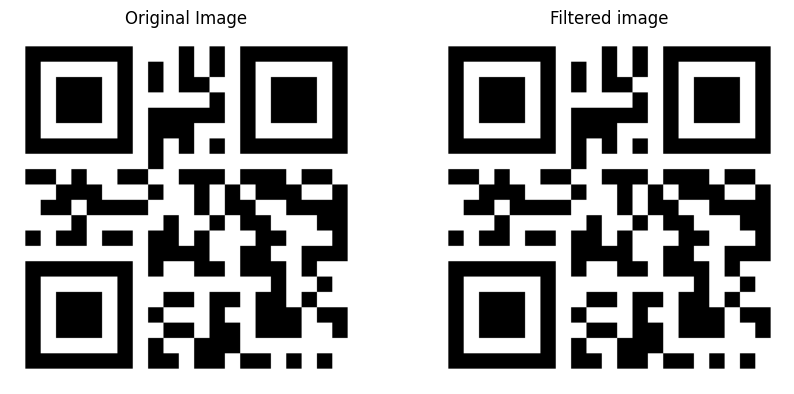

In [409]:
image = cv2.imread(img_address, cv2.IMREAD_GRAYSCALE)

img = cv2.imread(img_address, cv2.IMREAD_GRAYSCALE)
# img = cv2.GaussianBlur(img, (5, 5), 1)  # makes image blur
# img = cv2.Canny(img, 10, 50)  # makes image canny
test_case = TEST_CASE
img = detect_and_remove_sin_noise(img)

if RotateFlag:
   img = cv2.rotate(image, cv2.ROTATE_180)

# ******************************************************************************* #

# if test_case==1:
#     img = straighten_image(img)

# ******************************************************************************* #

if test_case == 3: # 04-Black-mirror
    img = flip_image(img)
    equalized_img = histogram_equalizer(img)
    _, threshold_image = cv2.threshold(equalized_img, 128, 255, cv2.THRESH_BINARY)
    # img = get_contours(threshold_image)
    img = invert_qr(threshold_image)
# ******************************************************************************* #

elif test_case == 4:
    filtersize = 41
    gaussianImg = cv2.GaussianBlur(img, (filtersize, filtersize), 128)
    # img = (img-gaussianImg)
    # #
    # kernel_size = (1, 509)  # Width is 0, height is 5 for vertical blur

# Apply vertical Gaussian blur
#     img = cv2.GaussianBlur(image, kernel_size, 0)
    _, img = cv2.threshold(gaussianImg, 127, 255, cv2.THRESH_BINARY)
    #
    square_se = cv2.getStructuringElement(cv2.MORPH_RECT, (21, 21))
    img = cv2.erode(img, square_se)
    img = cv2.dilate(img, square_se)

elif test_case == 5 or test_case == 1:
    # Load the original image
    edges_img = cv2.imread(img_address, cv2.IMREAD_GRAYSCALE)
    # Apply Canny edge detection
    edges_canny = cv2.Canny(image=edges_img, apertureSize=3, threshold1=120, threshold2=200, L2gradient=True)

    # Define Hough Transform parameters using sliders
    rho = 1
    theta_rad = 0.0035
    threshold = 118
    minLineLength = 640
    maxLineGap = 100

    # Detect lines using Hough Transform
    edges_hough_lines = cv2.HoughLinesP(edges_canny, rho, theta_rad, threshold, None, minLineLength, maxLineGap)

    # Create an image to draw the detected lines
    edges_hough = cv2.cvtColor((edges_img // 3) * 2, cv2.COLOR_GRAY2BGR)

    # Draw the detected lines on a copy of the original image
    image_with_lines = edges_img.copy()

    # Draw the detected lines on the image
    if edges_hough_lines is not None:
        for line in edges_hough_lines:
            x1, y1, x2, y2 = line[0]
            cv2.line(image_with_lines, (x1, y1), (x2, y2), (0, 0, 255), 2)

    img_gray_threshed = cv2.adaptiveThreshold(src=image_with_lines,
            maxValue=255,
            adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
            thresholdType=cv2.THRESH_BINARY_INV,
            blockSize=105,
            C=1
    )
    heightImg=924
    widthImg=924
    imgContours=image_with_lines.copy()
    imgBigContour=image_with_lines.copy()
    contours, hierarchy, =cv2.findContours(img_gray_threshed,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(imgContours,contours,-1,(255,50,0),10)
    biggest,maxArea=biggestContour(contours)
    if biggest.size !=0:
        biggest=reorder(biggest)
        cv2.drawContours(imgBigContour,biggest,-1,(0,0,0),45)

        pts1=np.float32(biggest)
        pts2=np.float32([[0,0],[widthImg,0],[0,heightImg],[widthImg,heightImg]])
        matrix=cv2.getPerspectiveTransform(pts1,pts2)
        imgWrapedgrey=cv2.warpPerspective(edges_img,matrix,(widthImg,heightImg))
        # imgDetectedDigits=imgBlank.copy()

    padding_size = 44
    # pad_width = 50
    imgWrapedgrey_padded =    cv2.copyMakeBorder(imgWrapedgrey, padding_size, padding_size, padding_size, padding_size, cv2.BORDER_CONSTANT, value=255)
        # imgWrapedColored=cv2.cvtColor(imgWarpColored,cv2.COLOR_BGR2GRAY)

    img = imgWrapedgrey_padded
# ******************************************************************************* #
elif test_case == 6:
    # img = adaptive_threshold(img,121,0.01)
    _, img = cv2.threshold(img, 60, 255, cv2.THRESH_BINARY)


# ******************************************************************************* #
elif test_case == 7:
    # square_se = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (21, 21))
    # img = cv2.erode(img, square_se)
    # img = cv2.dilate(img, square_se)
    square_se = cv2.getStructuringElement(cv2.MORPH_RECT, (21, 21))
    img = cv2.erode(img, square_se)
    img = cv2.dilate(img, square_se)
    img = cv2.dilate(img, square_se)
    img = cv2.erode(img, square_se)
    square_se = cv2.getStructuringElement(cv2.MORPH_RECT, (41, 41))
    img = cv2.erode(img, square_se)
    img = cv2.dilate(img, square_se)
        # img = cv2.dilate(img, square_se)
    # img = cv2.erode(img, square_se)

    show_histogram(img)
    _, img = cv2.threshold(img, 220, 255, cv2.THRESH_BINARY)
    # img = adaptive_threshold(img)

    # img[mask_binary == 255] = image1[mask_binary == 255]

# ******************************************************************************* #

elif test_case == 8:
    # img = detect_and_remove_sin_noise(image)

    # img = constrast_stretching(img)
    # img = sharpening_filter(img,27)

    sharpeninig_kernel = np.array([[-3,-3,-3],[-3,27,-3],[-3,-3,-3]])
    sharpened = cv2.filter2D(image,-1, sharpeninig_kernel)

    # img = adaptive_threshold(img, 101, 1)
    # image = np.mean(image, axis=2)
    img = binary_threshold(sharpened, 128)
    square_se = cv2.getStructuringElement(cv2.MORPH_RECT, (13, 13))
    img = cv2.erode(img, square_se)

    # Define the amount of shift (pixels)
    # Define the amount of shift (pixels)
    shift_amount = 50  # Adjust this value as needed

    # Create a blank white canvas with the desired shift
    shifted_image = np.ones_like(image) * 255  # Create a white canvas
    shifted_image[:, shift_amount:] = image[:, :-shift_amount]  # Overlay the original image onto the canvas

    # square_se = cv2.getStructuringElement(cv2.MORPH_RECT, (31, 31))
    # img = cv2.erode(img, square_se)


# ******************************************************************************* #

elif test_case == 9:
    img = constrast_stretching(img)
    img = histogram_equalizer(img)
    _, img = cv2.threshold(img, 220, 255, cv2.THRESH_BINARY)

# ******************************************************************************* #

elif test_case == 10:
    # Detect and remove sinusoidal noise
        # Convert to grayscale if needed

    # image = cv2.medianBlur(image, 21)

    if len(image.shape) > 2:
        image = np.mean(image, axis=2)
    img = detect_and_remove_sin_noise(image)
    # img = detect_and_remove_sin_noise(img)

    img = binary_threshold(img, 130)


# ******************************************************************************* #

elif test_case == 11:
    # Apply Gaussian blur to reduce noise
    median_img = median_filter(img,31)
    _, img = cv2.threshold(median_img, 128, 255, cv2.THRESH_BINARY)
    # square_se = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    # img = cv2.erode(img, square_se)
    # img = img - (threshold_image- cv2.dilate(img, square_se))
    # img = cv2.dilate(img, square_se)
    # img = cv2.erode(img, square_se)
    # _, img = cv2.threshold(img, 220, 255, cv2.THRESH_BINARY)
    # Perform edge detection using Canny
    # img = cv2.Canny(blurred, 50, 150)
    # show_histogram(median_filtered)
    # # creating a mask for the salt&pepper
    # # mask = np.zeros_like(median_filtered)
    # # mask[median_filtered < 5]   = 255
    # # mask[median_filtered > 250] = 255
    # # img = cv2.inpaint(median_filtered,mask,3,cv2.INPAINT_TELEA)
    #
    # img = try_highpass(dft_img, 20, gaussian=True, keep_dc=True)

# ******************************************************************************* #

elif test_case == 12:
    # Load the image
    img = cv2.imread(img_address)

    # Convert the image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Apply histogram equalization
    equalized_image = cv2.equalizeHist(gray)

    # Apply binary thresholding to make it black and white
    _, binary_image = cv2.threshold(equalized_image, 127, 255, cv2.THRESH_BINARY)

    # Apply erosion to fill in missing parts and remove noise
    kernel_size = 40  # Change the size of the kernel here
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    eroded_image = cv2.erode(binary_image, kernel, iterations=1)

    # Apply dilation to refine the image and fill missing parts
    dilation_kernel_size = 30  # Change the size of the dilation kernel here
    dilation_kernel = np.ones((dilation_kernel_size, dilation_kernel_size), np.uint8)
    img = cv2.dilate(eroded_image, dilation_kernel, iterations=1)


# ******************************************************************************* #

elif test_case == 13:
    # Load the original image
    edges_img = cv2.imread(img_address, cv2.IMREAD_GRAYSCALE)
    # Apply Canny edge detection
    edges_canny = cv2.Canny(image=edges_img, apertureSize=3, threshold1=650, threshold2=660, L2gradient=True)
    # _, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8));

    # Define Hough Transform parameters using sliders
    rho = 1               # @param {type:"slider", min:1, max:100, step:1}
    theta_rad = 0.00119    # @param {type:"slider", min:0.00001, max:0.1, step:0.00001}
    threshold = 25       # @param {type:"slider", min:0, max:400, step:1}
    minLineLength = 71    # @param {type:"slider", min:0, max:800, step:1}
    maxLineGap = 75

    # Detect lines using Hough Transform
    edges_hough_lines = cv2.HoughLinesP(edges_canny, rho, theta_rad, threshold, None, minLineLength, maxLineGap)

    # Create an image to draw the detected lines
    edges_hough = cv2.cvtColor((edges_img // 3) * 2, cv2.COLOR_GRAY2BGR)

    # Draw the detected lines on a copy of the original image
    image_with_lines = edges_img.copy()

    # Draw the detected lines on the image
    if edges_hough_lines is not None:
        for line in edges_hough_lines:
            x1, y1, x2, y2 = line[0]
            cv2.line(image_with_lines, (x1, y1), (x2, y2), (0, 0, 255), 2)

    img_gray_threshed = cv2.adaptiveThreshold(src=image_with_lines,
            maxValue=255,
            adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
            thresholdType=cv2.THRESH_BINARY_INV,
            blockSize=105,
            C=1
    )
    heightImg=924
    widthImg=924
    imgContours=image_with_lines.copy()
    imgBigContour=image_with_lines.copy()
    contours, hierarchy, =cv2.findContours(img_gray_threshed,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(imgContours,contours,-1,(255,50,0),10)
    biggest,maxArea=biggestContour(contours)
    if biggest.size !=0:
        biggest=reorder(biggest)
        cv2.drawContours(imgBigContour,biggest,-1,(0,255,0),20)
        if biggest.size != 0:
            biggest[-1][0][0] += 2.5  # Add 20 pixels to x-coordinate of the last point
            biggest[-1][0][1] += 5 # Add 20 pixels to y-coordinate of the last point

        for point in biggest:
            x, y = point[0]
            # cv2.circle(imgContours, (x, y), 10, (0, 0, 255), -1)
            print(f"Corner Point: ({x}, {y})")
        pts1=np.float32(biggest)
        pts2=np.float32([[0,0],[widthImg,0],[0,heightImg],[widthImg,heightImg]])
        matrix=cv2.getPerspectiveTransform(pts1,pts2)
        imgWrapedgrey=cv2.warpPerspective(edges_img,matrix,(widthImg,heightImg))
        # imgDetectedDigits=imgBlank.copy()
    imgWrapedgrey = binary_threshold(imgWrapedgrey, 129)
    padding_size = 44
    # pad_width = 50
    imgWrapedgrey_padded =    cv2.copyMakeBorder(imgWrapedgrey, padding_size, padding_size, padding_size, padding_size, cv2.BORDER_CONSTANT, value=255)
        # imgWrapedColored=cv2.cvtColor(imgWarpColored,cv2.COLOR_BGR2GRAY)

    img = imgWrapedgrey_padded
        # Get the size of the image
    height, width = img.shape[:2]

    # Print the size of the image
    print(f"Image Size: {width} x {height}")

# ******************************************************************************* #

fig, axes = plt.subplots(1, 2, figsize=(10, 10))

# Plot the original image
axes[0].imshow(image, cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')
axes[1].imshow(img, cmap = 'gray')
axes[1].set_title('Filtered image')
axes[1].axis('off')


In [410]:
# # img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
# hist = cv2.calcHist([image],[0],None,[256],[0,256])
#
# black_pixels = hist[0:128]
#
# # Find the intensity value with the maximum count (peak of the histogram)
# peak_intensity = np.argmax(black_pixels)
# print(peak_intensity)
# Equalized_image = False
# # Check if the count at the peak is greater than a certain threshold
# print(hist[peak_intensity])
# if hist[peak_intensity] > 600000:
#     print("Equalized")
#     Equalized_image = True
#     img_gray = cv2.equalizeHist(image)
#
# if hist[peak_intensity] < 2300 and hist[peak_intensity] > 2200:
#     print("Adaptively Equalized")
#
#     Equalized_image = True
#     Extend_Lines = True
#     clahe = cv2.createCLAHE(clipLimit=40.0, tileGridSize=(10, 10))
#     img_gray = clahe.apply(img_gray)
# #     result =  255 * (img_gray/255)**20
# if hist[peak_intensity] > 9500 and hist[peak_intensity] < 9600:
#     print("YES")
#     (T, img_gray) = cv2.threshold(image, 121, 255, cv2.THRESH_BINARY)
#
# plt.imshow(~image, cmap="gray");

## Use quiet zone to detect code area
Simply go through white rows and columns until you find the first black pixel from the left, from the right, from the top, and from the bottom.

In [411]:
start_row = -1
start_col = -1
end_row = -1
end_col = -1

for row_index, row in enumerate(img):
    non_white_count = 0
    # Checking the current row and the 10 rows below it
    for i in range(row_index, min(row_index + 20, img.shape[0])):
        if not all(pixel == 255 for pixel in img[i]):
            non_white_count += 1
            if non_white_count >= 20:
                start_row = row_index
                break
    if start_row != -1:
        break

for row_index, row in enumerate(img[::-1]):
    non_white_count = 0
    # Checking the current row and the 10 rows below it
    for i in range(row_index, min(row_index + 20, img.shape[0])):
        if not all(pixel == 255 for pixel in img[i]):
            non_white_count += 1
            if non_white_count >= 20:
                end_row = img.shape[0] - row_index
                break
    if end_row != -1:
        break

for col_index, col in enumerate(cv2.transpose(img)):
    non_white_count = 0
    # Checking the current row and the 10 rows below it
    for i in range(col_index, min(col_index + 20, img.shape[0])):
        if not all(pixel == 255 for pixel in img[i]):
            non_white_count += 1
            if non_white_count >= 20:
                start_col = col_index
                break
    if start_col != -1:
        break

for col_index, col in enumerate(cv2.transpose(img)[::-1]):
    non_white_count = 0
    # Checking the current row and the 10 rows below it
    for i in range(col_index, min(col_index + 20, img.shape[0])):
        if not all(pixel == 255 for pixel in img[i]):
            non_white_count += 1
            if non_white_count >= 20:
                end_col = img.shape[1] - col_index
                break
    if end_col != -1:
        break


if start_row >= 44*0.2: # allow 80% difference due to noise pixels
    start_row  = 44

if start_col >= 44*0.2: # allow 80% difference due to noise pixels
    start_col  = 44

if end_row >= 968*0.2: # allow 80% difference due to noise pixels
    end_row  = 968

if end_col >= 968*0.2:# allow 80% difference due to noise pixels
    end_col  = 968
#start_row = start_col = 44

# end_row = end_col = 968
print("start row: ", start_row, ", end row: ", end_row, ", start col: ", start_col, ", end col: ", end_col)
#get_qr_without_quiet_zone(img, start_row, end_row, start_col, end_col)

start row:  44 , end row:  968 , start col:  44 , end col:  968


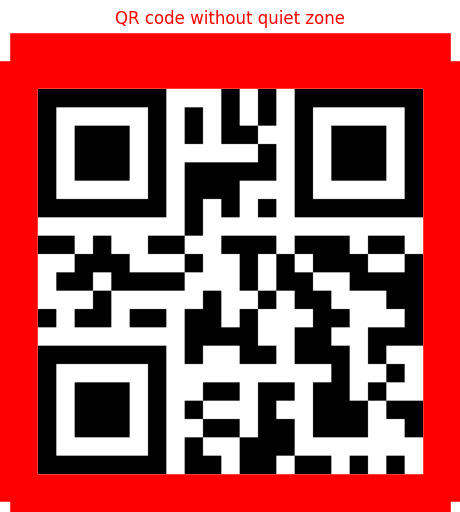

In [412]:
qr_no_quiet_zone = img[start_row:end_row, start_col:end_col]
fig = plt.figure(figsize=(5, 5))
plt.xticks([], [])
plt.yticks([], [])
fig.get_axes()[0].spines[:].set_color('red')
fig.get_axes()[0].spines[:].set_linewidth(40)
fig.get_axes()[0].spines[:].set_position(("outward", 20))
plt.title('QR code without quiet zone', y=1.15, color='red')
plt.imshow(qr_no_quiet_zone, cmap='gray')
#determine_grid_size(qr_no_quiet_zone)

## Use locator boxes to determine grid size
Since we know that the topleft pixel should be the border of the locator box, and that its size should be 7×7, we can determine the grid cell size by dividing its size in pixels by 7. How to get its size? It is a constant black row of pixels followed by one white cell. A simple for loop can get it done.

308
Grid cell size:  44
QR code shape: (924, 924)
Shape of qr_cells: (21, 21, 44, 44)


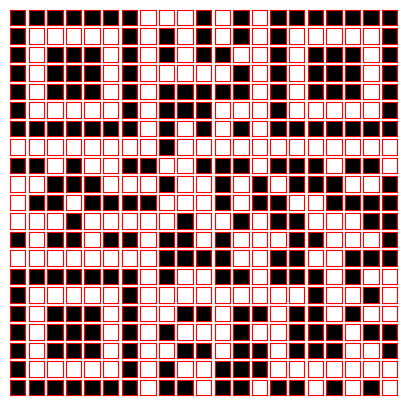

In [413]:
try:
# Initialize a list to store the counts of non-zero pixels at each position
    pixel_counts = [0] * len(qr_no_quiet_zone[0])

    # Iterate over the first 10 rows
    for row in qr_no_quiet_zone[:10]:
        for i, pixel in enumerate(row):
            # Check if the pixel is non-zero
            if (pixel != 0).any():
                # Increment the count for this position
                pixel_counts[i] += 1

    # Find the position with the maximum count
    most_common_position = np.argmax(pixel_counts)

    # Calculate the size based on the most common position
    size = most_common_position
    print(size)
    # If the size is larger than 30% of 308, set it to 308
    if size >= 308 * 0.3:
        size = 308

    # Calculate the grid cell size
    grid_cell_size = round(size / 7)

    # grid_cell_size = 44
    if start_col == 44 and end_col == 968 and grid_cell_size == 0:
      grid_cell_size = 44

    print("Grid cell size: ", grid_cell_size)
    if grid_cell_size != 0:
        grid_cells_num = round(qr_no_quiet_zone.shape[0] / grid_cell_size)
    else:
        print("Incorrect QR code detected")

    print("QR code shape:", qr_no_quiet_zone.shape)

    # Reshape the image into grid cells
    qr_cells = qr_no_quiet_zone.reshape((grid_cells_num, grid_cell_size, grid_cells_num, grid_cell_size)).swapaxes(1, 2)
    print("Shape of qr_cells:", qr_cells.shape)
    for i in range(14, 21):
        for j in range(6, 8):
            if j == 6:
                qr_cells[i, j] = 0
            else:
                qr_cells[i, j] = 255
    # Reshape the modified grid cells back into a flat array
    qr_modified_flat = qr_cells.swapaxes(1, 2).reshape(-1, grid_cell_size, grid_cell_size)
    # Fill each grid cell with the majority color
    for i in range(grid_cells_num):
        for j in range(grid_cells_num):
            cell = qr_cells[i][j]
            black_pixels = np.sum(cell == 0)
            white_pixels = np.sum(cell == 255)
            if black_pixels > white_pixels:
                qr_cells[i][j] = np.zeros_like(cell)
            else:
                qr_cells[i][j] = np.ones_like(cell) * 255

    # Plot the modified grid cells
    _, axes = plt.subplots(grid_cells_num, grid_cells_num, figsize=(5, 5))
    for i, row in enumerate(axes):
        for j, col in enumerate(row):
            col.imshow(qr_cells[i][j], cmap="gray", vmin=0, vmax=255)
            col.get_xaxis().set_visible(False)
            col.get_yaxis().set_visible(False)
            col.spines[:].set_color('red')

    # You can perform further processing or analysis here

except Exception as e:
    grid_cell_size = 44
    print("Error:", e)

## Convert grid tiles to numeric values

In [414]:
qr_cells_numeric = np.ndarray((grid_cells_num, grid_cells_num), dtype=np.uint8)
for i, row in enumerate(qr_cells):
    for j, cell in enumerate(row):
        qr_cells_numeric[i, j] = (np.median(cell) // 255)
print(qr_cells_numeric)
plt.show()

[[0 0 0 0 0 0 0 1 1 1 0 1 0 1 0 0 0 0 0 0 0]
 [0 1 1 1 1 1 0 1 0 1 0 1 0 1 0 1 1 1 1 1 0]
 [0 1 0 0 0 1 0 1 0 1 0 0 1 1 0 1 0 0 0 1 0]
 [0 1 0 0 0 1 0 1 1 1 1 1 0 1 0 1 0 0 0 1 0]
 [0 1 0 0 0 1 0 1 0 0 0 0 0 1 0 1 0 0 0 1 0]
 [0 1 1 1 1 1 0 1 0 0 0 1 1 1 0 1 1 1 1 1 0]
 [0 0 0 0 0 0 0 1 0 1 0 1 0 1 0 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 1 0 1 1 0 0 1 1 0 0 0 1 0 0 0 1 0 0 1]
 [1 1 0 0 0 1 1 1 0 1 1 0 1 0 1 0 0 0 1 1 0]
 [1 0 0 1 0 0 0 0 1 1 1 0 1 0 0 1 1 0 0 0 0]
 [1 1 1 0 1 1 1 1 1 0 1 1 0 1 0 0 1 1 1 0 0]
 [0 1 0 0 1 0 0 1 0 0 1 0 1 1 1 0 0 1 1 1 0]
 [1 1 1 1 1 1 1 1 0 0 0 0 1 1 0 0 1 1 0 0 0]
 [0 0 0 0 0 0 0 1 0 1 1 0 0 1 0 0 0 1 0 1 1]
 [0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 0 1]
 [0 1 0 0 0 1 0 1 1 0 0 1 0 0 1 0 0 1 0 1 1]
 [0 1 0 0 0 1 0 1 0 1 1 1 0 1 1 0 0 0 1 0 0]
 [0 1 0 0 0 1 0 1 1 0 0 1 0 0 1 0 0 0 1 1 0]
 [0 1 1 1 1 1 0 1 0 1 1 0 0 0 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 1 0 0 1 0 0 1 0 0 1 0 1 0 1]]


## Information extraction

![Alt text](https://upload.wikimedia.org/wikipedia/commons/thumb/3/3b/QR_Format_Information.svg/640px-QR_Format_Information.svg.png "a title")


### Error correction level

In [415]:
print(qr_cells_numeric[8])

[0 0 1 0 1 1 0 0 1 1 0 0 0 1 0 0 0 1 0 0 1]


In [416]:
# The first two bits determine the error correction level
# Level L (Low)         [11]	7%  of data bytes can be restored.
# Level M (Medium)      [10]	15% of data bytes can be restored.
# Level Q (Quartile)    [01]	25% of data bytes can be restored.
# Level H (High)        [00]	30% of data bytes can be restored.

ecl1 = []
for i in range(19, 21):
    ecl1.append(int(not qr_cells_numeric[i, 8]))
print("ECL1:", ecl1)

ecl = [int(not (c)) for c in qr_cells_numeric[8, 0:2]]
print("ECL:", ecl)

# Why "not"? Because the standard uses '1's for black and '0's for white
#
# "A dark module is a binary one and a light module is a binary zero."
#  - ISO/IEC 18004:2000(E)
#
# In image processing, we use them the other way.. Hence the inversion

# Error Correction Level determination based on the first two bits
if ecl1 == ecl:
    print("ECL correct:", ecl)
else:
    ecl = max(ecl, ecl1)
    print("Chosen Error Correction Level:", ecl)



if ecl == [0, 0]:
    print("level: High")
    error_level = 'H'

elif ecl == [0, 1]:
    print("level: Quartile")
    error_level = 'Q'

elif ecl == [1, 0]:
    print("level: Medium")
    error_level = 'M'

elif(ecl == [1,1]):
    print("level: Low")
    error_level = 'L'

# mask_pattern(qr_cells_numeric)

ECL1: [1, 1]
ECL: [1, 1]
[1, 1]
ECL correct: [1, 1]
level: Low


### Mask pattern

In [417]:
# Dictionary of all masks and their equivalent formulae
MASKS = {
    "000": lambda i, j: (i * j) % 2 + (i * j) % 3 == 0,
    "001": lambda i, j: (i / 2 + j / 3) % 2 == 0,
    "010": lambda i, j: ((i * j) % 3 + i + j) % 2 == 0,
    "011": lambda i, j: ((i * j) % 3 + i * j) % 2 == 0,
    "100": lambda i, j: i % 2 == 0,
    "101": lambda i, j: (i + j) % 2 == 0,
    "110": lambda i, j: (i + j) % 3 == 0,
    "111": lambda i, j: j % 3 == 0,
}

# Same row as above, the three cells after the ecl cells (converted to a string)
mask = [int(not (c)) for c in qr_cells_numeric[8, 2:5]]
mask_str = ''.join([str(c) for c in mask])
print("Mask 1:", mask_str)

# Mask from qr_cells_numeric[16:19, 2]
mask2 = [int(not (c)) for c in qr_cells_numeric[16:19, 2]]
mask_str2 = ''.join([str(c) for c in mask])
print("Mask 2:", mask_str2)

# Compare masks
if mask_str == mask_str2:
    print("Masks are the same")
else:
    print("Masks are different")

# Choose the maximum mask value
mask_str = max(mask_str, mask_str2)
print("Chosen mask:", mask_str)


# print("mask is: ", mask_str)
# format_error_correction(qr_cells_numeric)
# plt.show()

Mask 1: 010
Mask 2: 010
Masks are the same
Chosen mask: 010


### Format error correction

In [442]:
# Same row as above, but we want cells #5 and #7 (#6 is always set to 0),
#  followed by column #8 from cell #0 in it to cell #7 (and skipping #6)
fec = []
fec.append(qr_cells_numeric[8, 5])
fec.append(qr_cells_numeric[8, 7])
fec.extend(qr_cells_numeric[0:6, 8])
fec.extend(qr_cells_numeric[7:9, 8])
fec = [int(not (c)) for c in fec]
print(fec)
# FEC from another location
fec2 = []
fec2.append(qr_cells_numeric[15, 8])
fec2.append(qr_cells_numeric[14, 8])
fec2.extend(qr_cells_numeric[8, 13:21][::-1])
fec2 = [int(not (c)) for c in fec2]
print("FEC from another location:", fec2)

# Compare FECs
if fec == fec2:
    print("FECs are the same")
else:
    print("FECs are different")

# Choose the maximum FEC value
fec = max(fec, fec2)
print("Chosen FEC:", fec)

# print(fec)

[0, 1, 0, 1, 1, 0, 1, 1, 1, 0]
FEC from another location: [0, 1, 0, 1, 1, 0, 1, 1, 1, 0]
FECs are the same
Chosen FEC: [0, 1, 0, 1, 1, 0, 1, 1, 1, 0]


In [419]:
# So in total we have the following 15 bits of format info from our QR code
print(ecl, mask, fec)

[1, 1] [0, 1, 0] [0, 1, 0, 1, 1, 0, 1, 1, 1, 0]


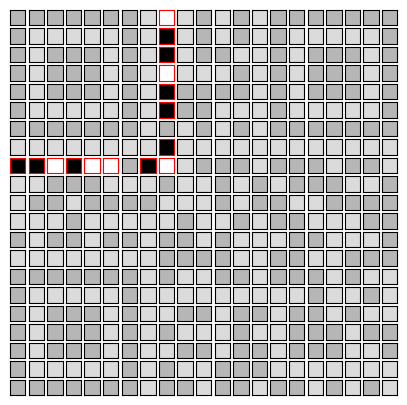

In [420]:

# Let's cross-check with our example
_, axes = plt.subplots(grid_cells_num, grid_cells_num, figsize=(5, 5))
for i, row in enumerate(axes):
    for j, col in enumerate(row):

        col.get_xaxis().set_visible(False)
        col.get_yaxis().set_visible(False)
        if (i == 8 and j <= 8) or (i <= 8 and j == 8):
            if (i != 6) and (j != 6):
                col.imshow(qr_cells[i][j], cmap="gray", vmin=0, vmax=255)
                col.spines[:].set_color('red')
                continue
        col.imshow(qr_cells[i][j], cmap="gray", vmin=-1275, vmax=510)
    # print(ecl, mask, fec)

In [421]:
# However..... You need to XOR that with the "format mask": 101010000010010
ecl[0] ^= 1
mask[0] ^= 1
mask[2] ^= 1
fec[5] ^= 1
fec[8] ^= 1

# And now we print...
print(ecl, mask, fec)

[0, 1] [1, 1, 1] [0, 1, 0, 1, 1, 1, 1, 1, 0, 0]


Data extraction
Message placement within a Ver 1 QR symbol (21×21).
![Alt text](https://upload.wikimedia.org/wikipedia/commons/thumb/2/21/QR_Character_Placement.svg/640px-QR_Character_Placement.svg.png "a title")
Message placement within a Ver 1 QR symbol (21×21). Example from wikipedia, encoded QR message is www.wikipedia.org

## Data extraction


In [422]:
# Before we proceed, let's write a function for masking to make our lives easier
UP, UP_ENC, DOWN, CW, CCW = range(5)  # A rather old-fashioned pythonic "Enum"

def apply_mask(data_start_i, data_start_j, direction):
    '''
    data_start_i/j represent the first cell's coords in its respective direction
    direction is the masking direction, up(-enc)/down/clockwise/anti-clockwise
    '''
    result = []
    row_offsets = []
    col_offsets = []
    if (direction in [UP, UP_ENC]):
        row_offsets = [0,  0, -1, -1, -2, -2, -3, -3]
        col_offsets = [0, -1,  0, -1,  0, -1,  0, -1]
    if (direction == DOWN):
        row_offsets = [0,  0,  1,  1,  2,  2,  3,  3]
        col_offsets = [0, -1,  0, -1,  0, -1,  0, -1]
    if (direction == CW):
        row_offsets = [0,  0,  1,  1,  1,  1,  0,  0]
        col_offsets = [0, -1,  0, -1, -2, -3, -2, -3]
    if (direction == CCW):
        row_offsets = [0,  0, -1, -1, -1, -1,  0,  0]
        col_offsets = [0, -1,  0, -1, -2, -3, -2, -3]

    for i, j in zip(row_offsets, col_offsets):
        cell = qr_cells_numeric[data_start_i+i, data_start_j+j]
        result.append(int(cell if MASKS[mask_str](data_start_i+i, data_start_j+j) else not cell))

    return result[:4] if direction == UP_ENC else result

### Data encoding

In [423]:
enc = apply_mask(grid_cells_num-1, grid_cells_num-1, UP_ENC)
print(enc)

[0, 1, 0, 0]


### Data length

In [424]:
length = apply_mask(grid_cells_num-3, grid_cells_num-1, UP)
print(length)

[0, 0, 0, 0, 1, 1, 0, 0]


### Data extraction

In [425]:
data_starting_indices = [
    [grid_cells_num-7, grid_cells_num-1, UP],
    [grid_cells_num-11, grid_cells_num-1, CCW],
    [grid_cells_num-10, grid_cells_num-3, DOWN],
    [grid_cells_num-6, grid_cells_num-3, DOWN],
    [grid_cells_num-2, grid_cells_num-3, CW],
    [grid_cells_num-3, grid_cells_num-5, UP],
    [grid_cells_num-7, grid_cells_num-5, UP],
    [grid_cells_num-11, grid_cells_num-5, CCW],
    [grid_cells_num-10, grid_cells_num-7, DOWN],
    [grid_cells_num-6, grid_cells_num-7, DOWN],
    [grid_cells_num-2, grid_cells_num-7, CW],
    [grid_cells_num-3, grid_cells_num-9, UP],
    [grid_cells_num-7, grid_cells_num-9, UP],
    [grid_cells_num-11, grid_cells_num-9, UP],
    [grid_cells_num-16, grid_cells_num-9, UP],
    [grid_cells_num-20, grid_cells_num-9, CCW],
    [grid_cells_num-19, grid_cells_num-11, DOWN],
    [grid_cells_num-14, grid_cells_num-11, DOWN],
    [grid_cells_num-10, grid_cells_num-11, DOWN],
    [grid_cells_num-6, grid_cells_num-11, DOWN],
    # Hmm..? I actually don't know how to proceed now lol
]
all_starting_indices = []
for i in range(grid_cells_num):
    for j in range(grid_cells_num):
        for direction in [UP, DOWN, CW, CCW]:
            all_starting_indices.append([i, j, direction])

# Find missing starting indices
missing_indices = []
for index in all_starting_indices:
    if index not in data_starting_indices:
        missing_indices.append(index)

if(len(length)>8):
# Append missing indices to data_starting_indices
    data_starting_indices.extend(missing_indices)

# Print the updated data_starting_indices list
print("Updated data_starting_indices")
counter = 0
ans = ''
for a, b, d in data_starting_indices:
    bits = apply_mask(a, b, d)
    bit_string = ''.join([str(bit) for bit in bits])
    if bit_string[:4] == "0000" and counter>6:
        print(f'{bit_string[:4]} = 0 (NULL TERMINATOR)')
        break
    ans += chr(int(bit_string, 2)) # converts to binary to int, then to ASCII
    print(f'{bit_string} = {ans[-1]}')
    counter +=1

print(f'\nDecoded string: {ans}')

Updated data_starting_indices
00110000 = 0
00110001 = 1
00101101 = -
01000111 = G
01101111 = o
01101111 = o
01100100 = d
00100000 =  
01101010 = j
01101111 = o
01100010 = b
00100001 = !
0000 = 0 (NULL TERMINATOR)

Decoded string: 01-Good job!


In [426]:
# from reedsolo import RSCodec
#
# # Convert the string to a list of integers (byte values)
# data_bytes = [ord(char) for char in ans]
#
# # Determine the number of error correction bytes per block based on the QR code version and error correction level
# # For example:
# error_level = 'H'  # Use the error correction level obtained from your code
# if error_level == 'H':
#     num_ec_bytes_per_block = 30  # Example value, adjust based on your calculation
# else:
#     # Add conditions for other error correction levels if needed
#     pass
#
# # Create an RSCodec object
# rs = RSCodec(num_ec_bytes_per_block)
#
# # Encode the data using Reed-Solomon
# encoded_data = rs.encode(data_bytes)
#
# # Now encoded_data contains both the original data and the error correction c

In [427]:
# # Convert the list of integers back to a string
# encoded_string = ''.join(chr(byte) for byte in encoded_data)
#
# # Print the encoded string
# print("Encoded data:", encoded_string)

In [428]:
# # Print the list of integers
# print("Encoded data:", encoded_data)